### 1. Loading data from url

First, one of the requirements is that it takes in data directly from the specified url.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml

%matplotlib inline

url = '<INSERT URL>'

In [2]:
data = pd.read_csv(url)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8573 entries, 0 to 8572
Data columns (total 9 columns):
holiday                8573 non-null object
temp                   8573 non-null float64
rain_1h                8573 non-null float64
snow_1h                8573 non-null int64
clouds_all             8573 non-null int64
weather_main           8573 non-null object
weather_description    8573 non-null object
date_time              8573 non-null object
traffic_volume         8573 non-null int64
dtypes: float64(2), int64(3), object(4)
memory usage: 602.9+ KB


In [4]:
data['date_time'] = pd.to_datetime(data['date_time'])

In [5]:
data.set_index("date_time",inplace=True)

In [6]:
data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2013-01-01 00:00:00,New Years Day,263.49,0.0,0,58,Clouds,broken clouds,1439
2013-01-01 01:00:00,None,263.78,0.0,0,40,Clouds,scattered clouds,1502
2013-01-01 02:00:00,None,264.16,0.0,0,75,Snow,heavy snow,933
2013-01-01 03:00:00,None,263.95,0.0,0,90,Clouds,overcast clouds,576
2013-01-01 04:00:00,None,263.65,0.0,0,90,Clouds,overcast clouds,372
...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,None,248.13,0.0,0,1,Clear,sky is clear,4504
2013-12-31 20:00:00,None,247.66,0.0,0,1,Clear,sky is clear,3478
2013-12-31 21:00:00,None,248.63,0.0,0,1,Clear,sky is clear,2711


### 2. Distribution of variables

First, let's take a quick look at the columns to see what sort of data we are working with.

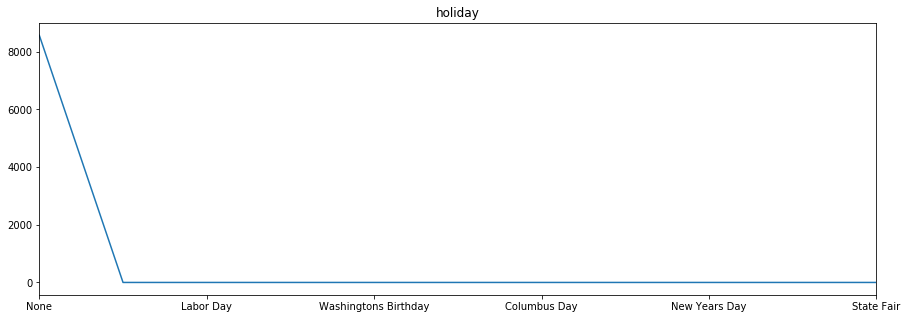

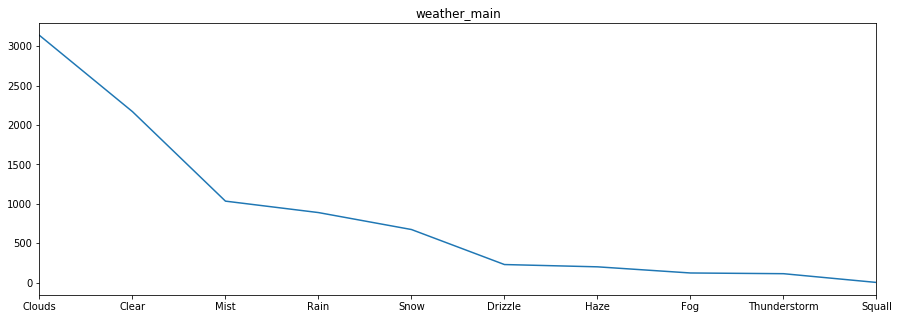

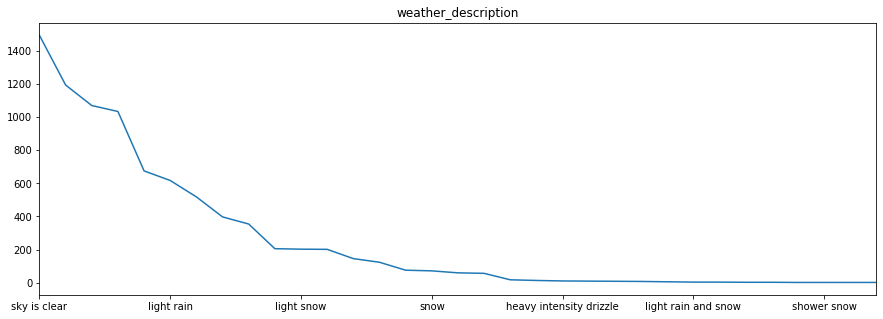

In [7]:
for col in data.columns:
    if data[col].dtypes == 'O':
        plt.figure(col,figsize=(15,5))
        plt.title(col)
        data[col].value_counts().plot()

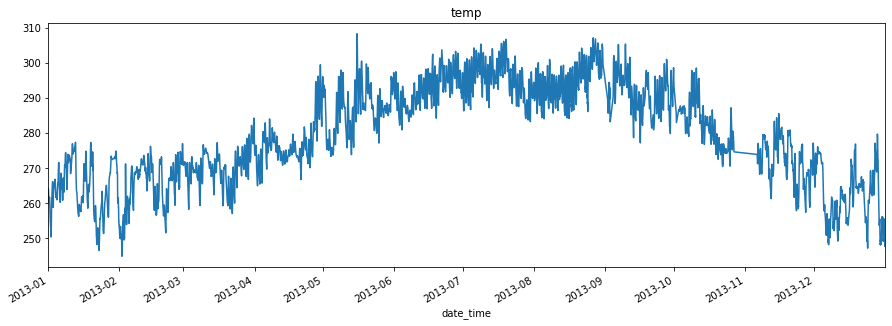

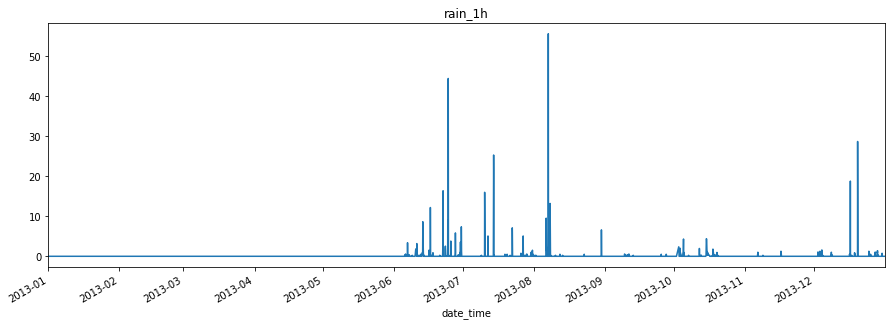

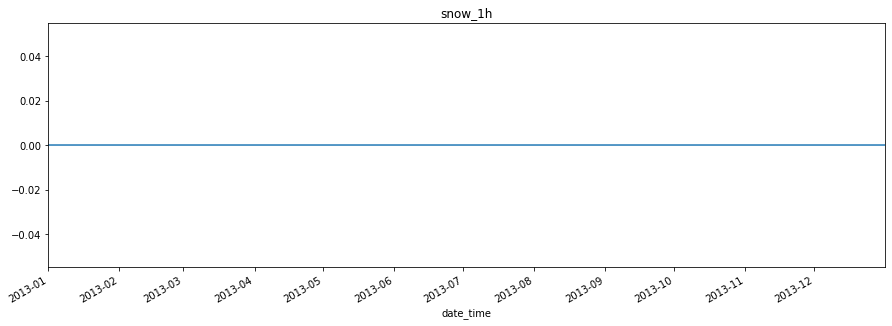

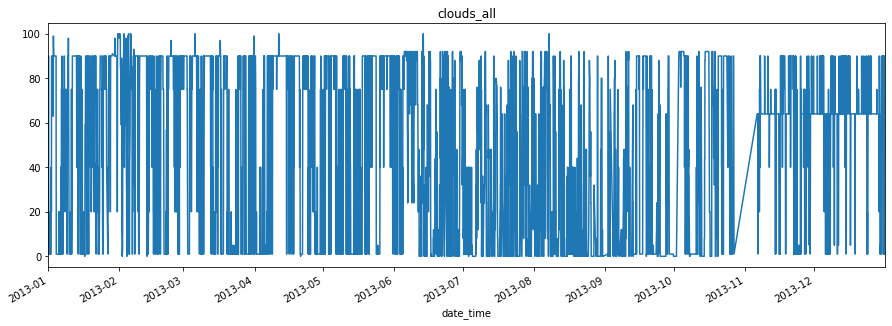

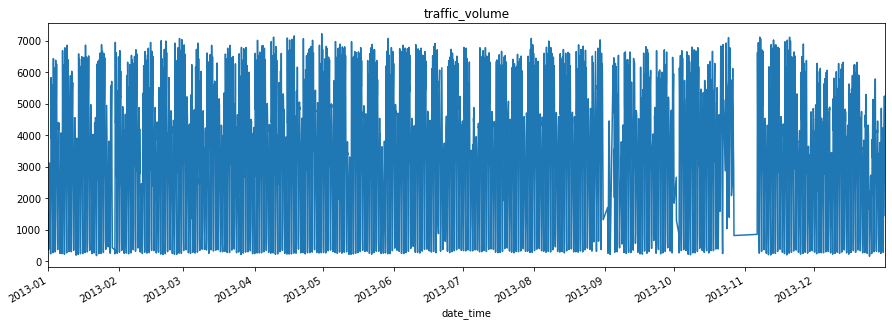

In [8]:
for col in data.columns:
    if data[col].dtypes != 'O':
        plt.figure(col,figsize=(15,5))
        plt.title(col)
        data[col].plot()

#### Holiday
There are only a few instances of holidays scattered throughout the year. Most of the values are none.

#### Weather_main, weather_description
Weather main is the main type of weather, while weather description goes further in depth on the type of weather.
Most of the days are cloudy, clear, misty, rainy or snowy. I will most likely keep only 1 column for the modelling to avoid collinearity.

#### Temp
We note that temperature has a seasonal pattern annually.

#### Rainfall
Rain is sporadic through the year with no discernible pattern except that it only occurs in the later half of the year.

#### Snow
Despite the weather columns having 'snow' as a type, snow is recorded at 0 throughout. I will drop this column.

#### Clouds
No discernible pattern, random and high variance - to look at relationship with target variable later. I suspect there will be very little correlation.

#### Traffic volume (target)
Looks like it has a seasonal component on a daily/weekly basis - it would be good to take a deeper look in the relationship it has with time.

### 3. Predictor variables vs target variable

Now, I'll take a look at the different variables vs traffic volume.

For categorical variables, I'll plot a bar graph using seaborn, which would give us an idea on the mean and range of the traffic volume across the categories.

For numeric variables, I'll take a look at the R coefficient with traffic_volume.

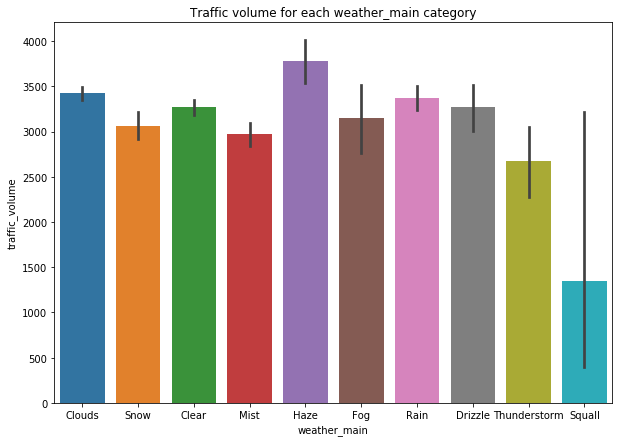

In [9]:
plt.figure(figsize=(10,7))
plt.title('Traffic volume for each weather_main category')
sns.barplot(x='weather_main',y='traffic_volume',data=data)

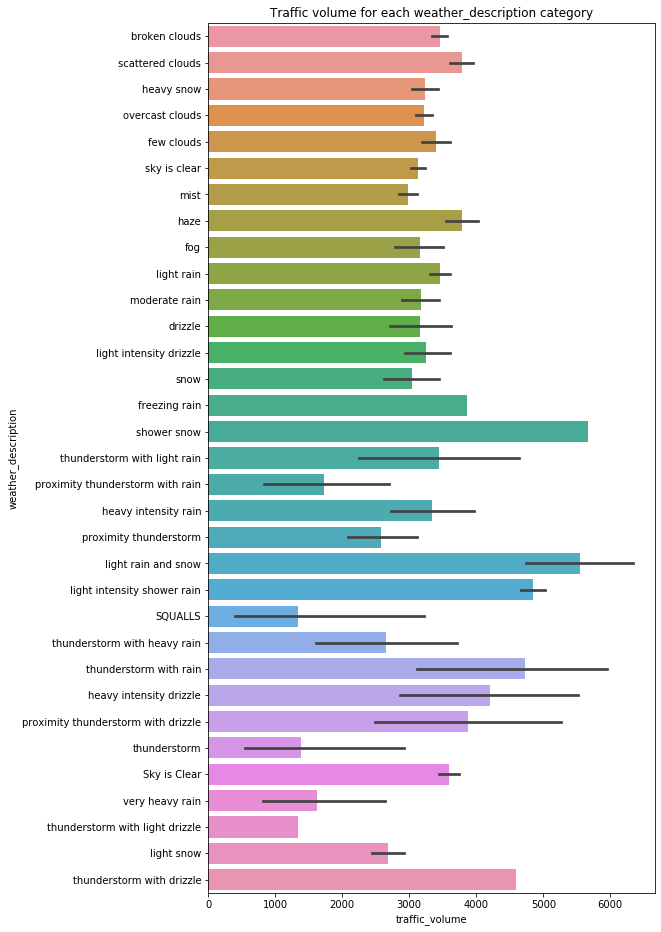

In [10]:
plt.figure(figsize=(8,16))
plt.title('Traffic volume for each weather_description category')
sns.barplot(x='traffic_volume',y='weather_description',data=data)

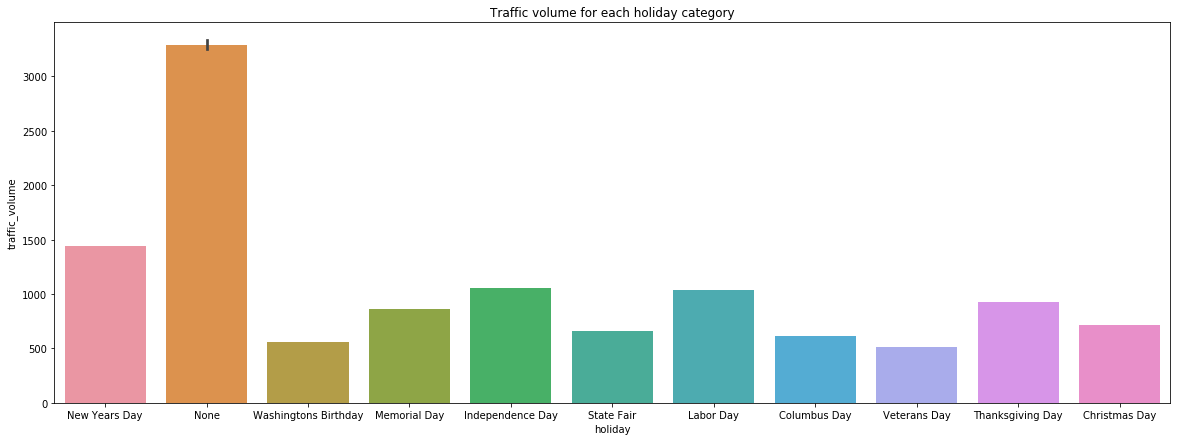

In [11]:
plt.figure(figsize=(20,7))
plt.title('Traffic volume for each holiday category')
sns.barplot(x='holiday',y='traffic_volume',data=data)

In [12]:
data.corr()['traffic_volume']

temp              0.152234
rain_1h          -0.032439
snow_1h                NaN
clouds_all       -0.002702
traffic_volume    1.000000
Name: traffic_volume, dtype: float64

It looks like there are clear relationships between traffic volume for weather_main, and not so much for weather_description. Certain categories such as 'thunderstorm with rain' have a higher traffic volume than 'Sky is Clear', which makes no sense and is probably due to small sample size and other features. Most likely I will drop weather_description and keep weather_main and it gives us a better generalisation of traffic volume.

It seems traffic volumes are different across each holiday - however, as there is only 1 instance of each holiday, it is not statistically significant. It may be better to generalise it and use a binary variable to denote if it's a holiday or not.

Temperature, rain and clouds have very low correlation with traffic volume.

Next, let's try doing some feature engineering on the timestamp.

In [13]:
data['day_of_week']=[i.weekday() for i in data.index]
data['day_of_week']= data['day_of_week'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun',})
data['hour']=[i.hour for i in data.index]
data['month']=[i.month for i in data.index]
data['day']=[i.day for i in data.index]

for col in ['hour','month','day']:
    data[col] = data[col].astype(object)

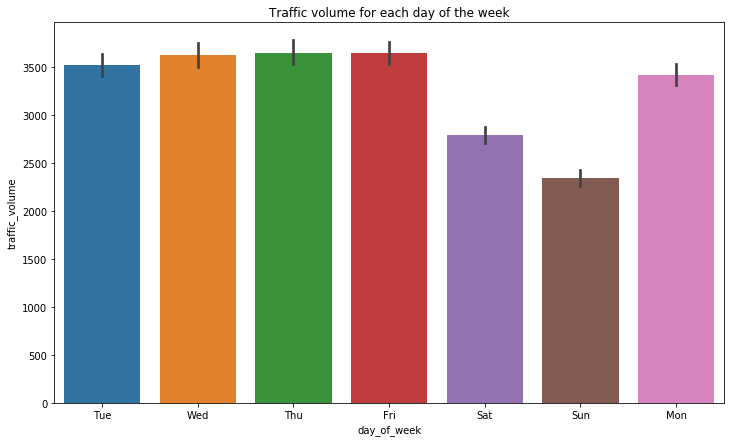

In [14]:
plt.figure(figsize=(12,7))
plt.title('Traffic volume for each day of the week')
sns.barplot(x='day_of_week',y='traffic_volume',data=data)

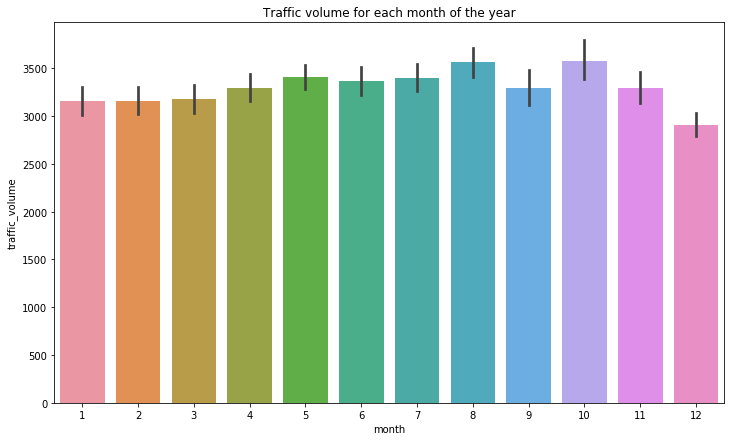

In [15]:
plt.figure(figsize=(12,7))
plt.title('Traffic volume for each month of the year')
sns.barplot(x='month',y='traffic_volume',data=data)

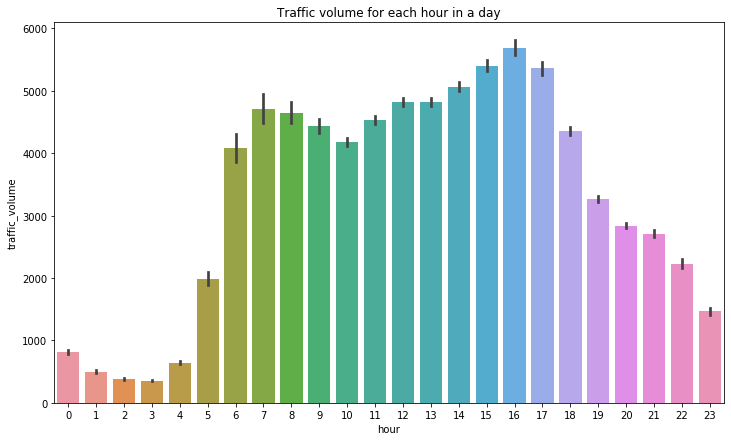

In [16]:
plt.figure(figsize=(12,7))
plt.title('Traffic volume for each hour in a day')
sns.barplot(x='hour',y='traffic_volume',data=data)

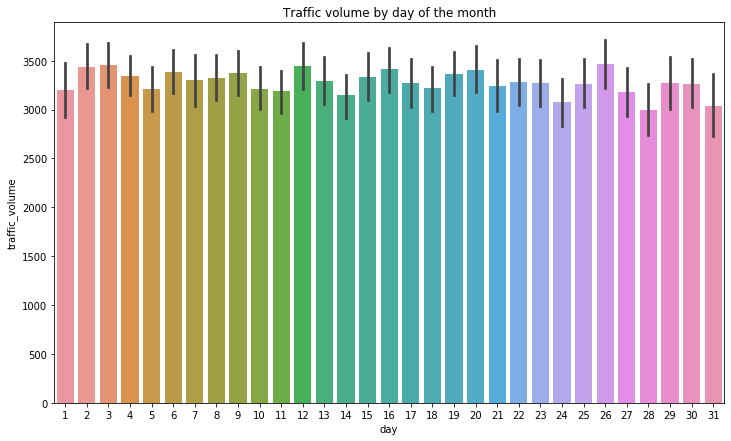

In [17]:
plt.figure(figsize=(12,7))
plt.title('Traffic volume by day of the month')
sns.barplot(x='day',y='traffic_volume',data=data)

From the graphs, there is a noticeable difference in traffic volume across the day of the week, as well as the hour, and not so much for the month, and almost no difference for the day of the month.

Data to drop: Day of the month (1-31), weather_description, rain_1h, clouds_all (Keeping temp for now)

In [18]:
data.drop(['day','snow_1h','rain_1h','clouds_all','weather_description'],axis=1,inplace=True)

### 4. Modelling testing

In this section I will be testing out the performances of different models for this regression problem (predicting volume of traffic). Given the dataset, it is possible that you could approach this in a variety of ways - standard time series models using only traffic volume, traditional supervised machine learning models using the various features as inputs as well as neural networks.

However, given that the dataset is only for 1 year, time series models are difficult to apply. In addition, given the low amount of data points (8k+ rows), neural networks will probably not outperform standard supervised learning models.

Hence, I will be mainly using the classic regression models such as linear regression, random forests and gradient boosting trees.

In [19]:
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.linear_model import LinearRegression,LassoCV,Lasso,Ridge,RidgeCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error,r2_score

In [20]:
data['holiday']=data['holiday'].map({'None':0})
data['holiday'].fillna(value=1,inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8573 entries, 2013-01-01 00:00:00 to 2013-12-31 23:00:00
Data columns (total 7 columns):
holiday           8573 non-null float64
temp              8573 non-null float64
weather_main      8573 non-null object
traffic_volume    8573 non-null int64
day_of_week       8573 non-null object
hour              8573 non-null object
month             8573 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 855.8+ KB


In [21]:
for col in data.columns:
    if data[col].dtypes=='O':
        data = pd.concat([data,pd.get_dummies(data[col],drop_first=True)],axis=1)
        data.drop(col,axis=1,inplace=True)

In [22]:
data_y = data['traffic_volume']
data_x = data.drop(['traffic_volume'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)

After processing the categorical variables using get_dummies, I then do a train_test_split of 80-20.

First, I will start with the GLMs.

In [23]:
lr = LinearRegression()
lr.fit(X_train,y_train)
print('R2:',lr.score(X_test,y_test))
print('MSE:',mean_squared_error(y_test,lr.predict(X_test)))
print('CV:',np.average(cross_val_score(lr,X_train,y_train,cv=5)))

R2: 0.8313014860175946
MSE: 686338.2788638391
CV: 0.8356921274135052


In [24]:
lassorange = np.linspace(0,5,300)
lcv = LassoCV(alphas = lassorange)
lcv.fit(X_train,y_train)
print('Best alpha:',lcv.alpha_)

lasso = Lasso(alpha=lcv.alpha_)
lasso.fit(X_train,y_train)
print('R2:',lasso.score(X_test,y_test))
print('MSE:',mean_squared_error(y_test,lasso.predict(X_test)))
print('CV:',np.average(cross_val_score(lasso,X_train,y_train,cv=5)))

C:\Users\User\Anaconda3\envs\DS3.6\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\envs\DS3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\User\Anaconda3\envs\DS3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1501719645.0554848, tolerance: 1871810.3826417322
  tol, rng, random, positive)
C:\Users\User\Anaconda3\envs\DS3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random

Best alpha: 0.08361204013377926
R2: 0.8313567332063221
MSE: 686113.5094836692
CV: 0.8357164824174221


In [25]:
ridgerange = np.logspace(-2,7,300)
rcv = RidgeCV(alphas = ridgerange)
rcv.fit(X_train,y_train)
print('Best alpha:',rcv.alpha_)

ridge = Ridge(alpha=rcv.alpha_)
ridge.fit(X_train,y_train)
print('R2:',ridge.score(X_test,y_test))
print('MSE:',mean_squared_error(y_test,ridge.predict(X_test)))
print('CV:',np.average(cross_val_score(ridge,X_train,y_train,cv=5)))

Best alpha: 0.037316968377327536
R2: 0.8313076120789893
MSE: 686313.3554052105
CV: 0.835693079833191


An R2 score above 0.8 is a pleasant surprise, though this is mostly attributable to the categorical variables as the numerical variables had very low correlation.

Let's see if we can do better with tree-based models.

In [26]:
rfc = RandomForestRegressor(n_estimators=200,random_state=42,n_jobs=-1)
rfc.fit(X_train,y_train)
print('R2:',rfc.score(X_test,y_test))
print('MSE:',mean_squared_error(y_test,rfc.predict(X_test)))
print('CV:',np.average(cross_val_score(rfc,X_train,y_train,cv=5)))

R2: 0.9233289106938819
MSE: 311931.0433194752
CV: 0.9378531463145293


In [27]:
lgb = LGBMRegressor(learning_rate=0.1,n_estimators=2000)
lgb.fit(X_train,y_train)
print('R2:',lgb.score(X_test,y_test))
print('MSE:',mean_squared_error(y_test,lgb.predict(X_test)))
print('CV:',np.average(cross_val_score(lgb,X_train,y_train,cv=5)))

R2: 0.9405585235859933
MSE: 241833.55058699375
CV: 0.9545112663218454


Even with minimal tuning, R2 scores of above 0.9 are achievable, with similar test r2 and CV r2 scores.

This only really means that the dataset has very good predictive power. It also appears that regularisation for linear models does not add much, so I will leave them out in section 2.

Now, I'll try splitting the data based on the timestamp. Let's try training using the first 80% rows and testing using the last 20% rows.

In [28]:
X_train = data_x.iloc[:int(data_x.shape[0]*0.8)]
y_train = data_y.iloc[:int(data_x.shape[0]*0.8)]
X_test = data_x.iloc[int(data_x.shape[0]*0.8):]
y_test = data_y.iloc[int(data_x.shape[0]*0.8):]

In [29]:
lr = LinearRegression()
lr.fit(X_train,y_train)
print('R2:',lr.score(X_test,y_test))
print('MSE:',mean_squared_error(y_test,lr.predict(X_test)))
print('CV:',np.average(cross_val_score(lr,X_train,y_train,cv=5)))

R2: 0.7963905563422746
MSE: 783008.2004169857
CV: 0.8217643502962062


In [30]:
lassorange = np.linspace(0,5,300)
lcv = LassoCV(alphas = lassorange)
lcv.fit(X_train,y_train)
print('Best alpha:',lcv.alpha_)

lasso = Lasso(alpha=lcv.alpha_)
lasso.fit(X_train,y_train)
print('R2:',lasso.score(X_test,y_test))
print('MSE:',mean_squared_error(y_test,lasso.predict(X_test)))
print('CV:',np.average(cross_val_score(lasso,X_train,y_train,cv=5)))

C:\Users\User\Anaconda3\envs\DS3.6\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\envs\DS3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
C:\Users\User\Anaconda3\envs\DS3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1470984699.421009, tolerance: 1955743.308388692
  tol, rng, random, positive)
C:\Users\User\Anaconda3\envs\DS3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:471: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, 

Best alpha: 1.6722408026755853
R2: 0.7943305118058706
MSE: 790930.3858335923
CV: 0.831405163407857


In [31]:
ridgerange = np.logspace(-2,7,300)
rcv = RidgeCV(alphas = ridgerange)
rcv.fit(X_train,y_train)
print('Best alpha:',rcv.alpha_)

ridge = Ridge(alpha=rcv.alpha_)
ridge.fit(X_train,y_train)
print('R2:',ridge.score(X_test,y_test))
print('MSE:',mean_squared_error(y_test,ridge.predict(X_test)))
print('CV:',np.average(cross_val_score(ridge,X_train,y_train,cv=5)))

Best alpha: 0.039995090972036657
R2: 0.7964593259949286
MSE: 782743.7372319755
CV: 0.8218495931616907


In [32]:
rfc = RandomForestRegressor(n_estimators=200,random_state=42,n_jobs=-1)
rfc.fit(X_train,y_train)
print('R2:',rfc.score(X_test,y_test))
print('MSE:',mean_squared_error(y_test,rfc.predict(X_test)))
print('CV:',np.average(cross_val_score(rfc,X_train,y_train,cv=5)))

R2: 0.8630209381753011
MSE: 526771.8764286061
CV: 0.9358612011252353


In [33]:
lgb = LGBMRegressor(learning_rate=0.1,n_estimators=1000)
lgb.fit(X_train,y_train)
print('R2:',lgb.score(X_test,y_test))
print('MSE:',mean_squared_error(y_test,lgb.predict(X_test)))
print('CV:',np.average(cross_val_score(lgb,X_train,y_train,cv=5)))

R2: 0.861146008097937
MSE: 533982.1786592457
CV: 0.927864762937257


As expected, the models perform worse on data they have not learned from (due to being split by time). I will also add this as an option for train-test-split in section 2.